 # Grover's Algorithm and Amplitude Amplification
 
 ## Grover's search algorithm

The algorithm is often described as finding "a needle in a haystack".
Suppose we have a large search space of size $N$, and one (or more) of the elements is special.
If a classical algorithm, in the worst case we would need to look through all $N$ elements to find our solution(s).
In a randomized algorithm, we would expect to find the solution in $\frac{N}{2}$, still $O(N).

Grover can do this in about $O(\sqrt{N})$ iterations.

### How does it work

We use a black-box function, or Oracle, that can quickly verify that an input is a solution to some problem.

In our set-up, using the QISKIT components, the Oracle marks the correct solution by flipping the *phase* of the correct state.  
We will see that we do this by setting up a Unitary matrix operator, with the phase flipped.

We can think of this as nudging, or jiggling, the quantum state in a way that attracts it to the desired solution state.

The algorithm then has three steps:

1. Start in complete ignorance (Equal supposition).  We setup a state that all possible answers are equally likely by applying the Hadamard gate to all qubits.

1. Construct an Oracle gate to mark the correct state.

1. Amplify the correct answer by applying the *Grover Diffusion Operator* to reflect the quantum state around the average amplitude.  For each iteration, the amplitude (probability) of the correct answer increases, and the others decrease.

When we  measure the qubits at the end of these iterations, we will have, with a high probability, the correct answer.


With 4 qubits, we have a hilbert space of size 16
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0

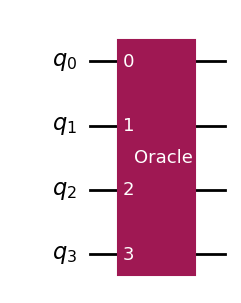

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# Create oracle matrix
n = 4
solutions = [3, 5]
size = 2 ** n
oracle = np.eye(size)
for idx in solutions:
    oracle[idx, idx] = -1
print(f"With {n} qubits, we have a hilbert space of size {2 ** n}")
print(oracle)

# Convert to quantum circuit
oracle_circuit = QuantumCircuit(n)
oracle_circuit.unitary(oracle, range(n), label="Oracle")
oracle_circuit.draw("mpl")

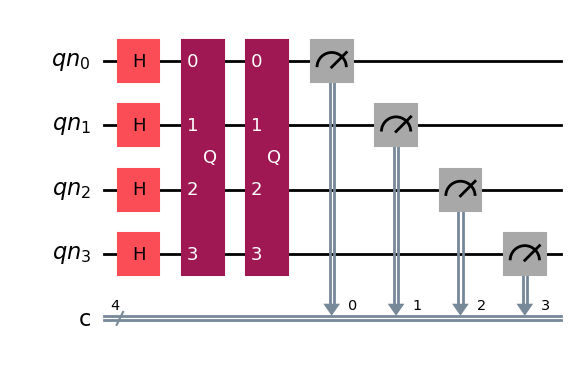

In [2]:
# Calculate optimal number of iterations
k = max(1, int(np.floor((np.pi / 4) * np.sqrt(2 ** n / len(solutions)))), 0)

# Create quantum and classical registers
qn = QuantumRegister(n, 'qn')
c = ClassicalRegister(n, 'c')
qc = QuantumCircuit(qn, c)

# Initialize superposition
qc.h(qn)
        
# Create the grover operator to apply the reflections, and apply for k iterations
grover_operator = GroverOperator(oracle_circuit)

for _ in range(k):
    qc.append(grover_operator, qn)

# Measure results
qc.measure(qn, c)
qc.draw("mpl")

Simple Grover's Algorithm Circuit
Searching for 2 solutions in 16 states
Number of iterations: 2

Circuit Statistics:
Qubits: 4
Gates: 10
Depth: 4


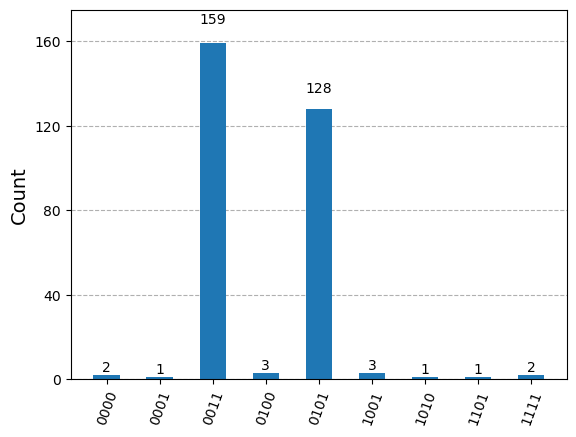

In [3]:
print(f"Simple Grover's Algorithm Circuit\n"
            f"Searching for {len(solutions)} solution{'s' if len(solutions)>1 else ''} "
            f"in {2**n} states\n"
            f"Number of iterations: {qc.count_ops().get('Q', 0)}\n")

print(f"Circuit Statistics:\n"
                f"Qubits: {n}\n"
                f"Gates: {sum(qc.count_ops().values())}\n"
                f"Depth: {qc.depth()}")

# Run simulation
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
result = simulator.run(qc_t, shots=300).result()
counts = result.get_counts()

plot_histogram(counts)

## Running Grover’s algorithm

This is the code from the IBM tutorial [IBM QISKIT Grover notebook source](https://qiskit-community.github.io/qiskit-algorithms/tutorials/06_grover.html)

Specify an oracle for the circuit of Grover’s algorithm.

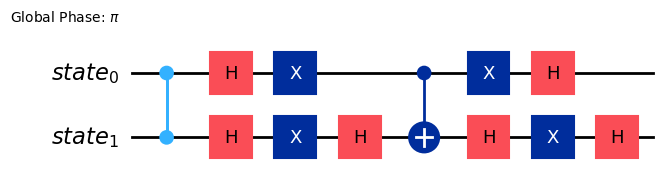

In [4]:
from qiskit import QuantumCircuit
from qiskit_algorithms import AmplificationProblem

# the state we desire to find is '11'
good_state = ["11"]

# specify the oracle that marks the state '11' as a good solution
oracle = QuantumCircuit(2)
oracle.cz(0, 1)

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)

# now we can have a look at the Grover operator that is used in running the algorithm
# (Algorithm circuits are wrapped in a gate to appear in composition as a block
# so we have to decompose() the op to see it expanded into its component gates.)
problem.grover_operator.decompose().draw(output="mpl")

Specify a backend to execute the circuits.  Notice that we find a "good state" in the 'top_measurement'.

In [5]:
from qiskit_algorithms import Grover
from qiskit.primitives import Sampler

grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
print("Result type:", type(result))
print()
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)

Result type: <class 'qiskit_algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11


/var/folders/1r/88yy9y2s19n70brn4mjzj3q80000gn/T/ipykernel_59444/4134062562.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


We can use different QISKIT components as an Oracle.  Here is the same example, but using the `StateVector` instead.

In [6]:
from qiskit.quantum_info import Statevector

oracle = Statevector.from_label("11")
problem = AmplificationProblem(oracle, is_good_state=["11"])

grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
print("Result type:", type(result))
print()
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)

Result type: <class 'qiskit_algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11


/var/folders/1r/88yy9y2s19n70brn4mjzj3q80000gn/T/ipykernel_59444/1906973721.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


Internally, the statevector is mapped to a quantum circuit:

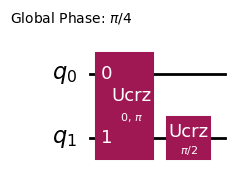

In [7]:
problem.grover_operator.oracle.decompose().draw(output="mpl")

Qiskit allows for an easy construction of more complex oracles.  
`PhaseOracle` is used for parsing logical expressions such as '~a | b', and is useful for solving 3-SAT problems.

Here we use the `PhaseOracle` for the simple example of finding the state $|11>$, which corresponds to 'a & b'

It does this by implementing a phase flip when the state is $|11>$.

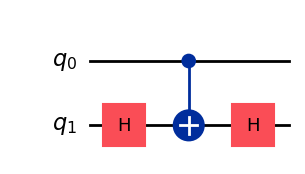

In [8]:
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.exceptions import MissingOptionalLibraryError

# `Oracle` (`PhaseOracle`) as the `oracle` argument
expression = "(a & b)"
try:
    oracle = PhaseOracle(expression)
    problem = AmplificationProblem(oracle)
    display(problem.grover_operator.oracle.decompose().draw(output="mpl"))
except MissingOptionalLibraryError as ex:
    print(ex)

### Amplitude Amplification

Grover’s algorithm uses Hadamard gates to create the uniform superposition of all the states at the beginning of the Grover operator . If some information on the good states is available, it might be useful to not start in a uniform superposition but only initialize specific states. This, generalized, version of Grover’s algorithm is referred to Amplitude Amplification.

state preparation circuit:


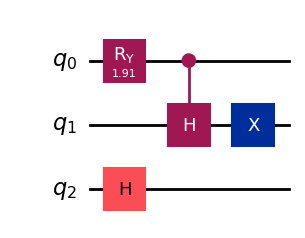

In [9]:
import numpy as np

# Specifying `state_preparation`
# to prepare a superposition of |01>, |10>, and |11>
oracle = QuantumCircuit(3)
oracle.ccz(0, 1, 2)

theta = 2 * np.arccos(1 / np.sqrt(3))
state_preparation = QuantumCircuit(3)
state_preparation.ry(theta, 0)          # Single-qubit rotation about the Y axis.
state_preparation.ch(0, 1)              # Applies a Hadamard on the target qubit if the control is in the ∣1⟩ state.
state_preparation.x(1)
state_preparation.h(2)

# we only care about the first two bits being in state 1, thus add both possibilities for the last qubit
problem = AmplificationProblem(
    oracle, state_preparation=state_preparation, is_good_state=["110", "111"]
)

# state_preparation
print("state preparation circuit:")
problem.grover_operator.state_preparation.draw(output="mpl")

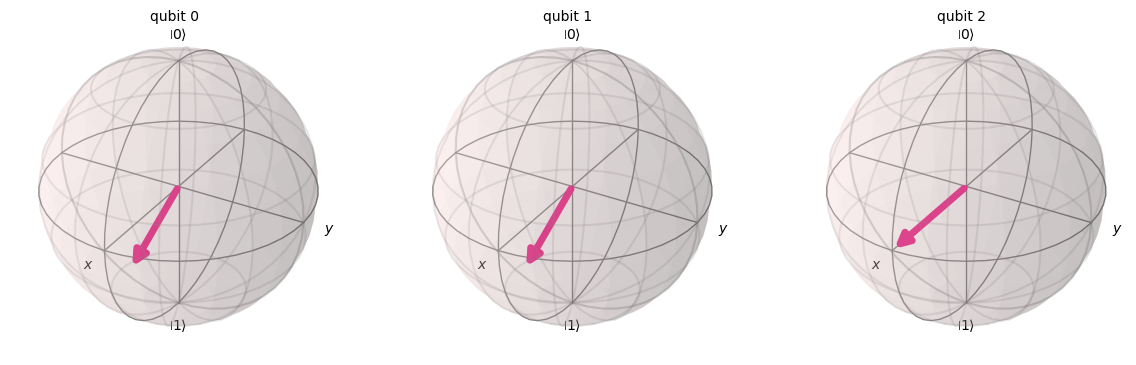

In [10]:
from qiskit.visualization import plot_bloch_multivector
state = Statevector(state_preparation)
plot_bloch_multivector(state)

In [11]:
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)

Success!
Top measurement: 111


/var/folders/1r/88yy9y2s19n70brn4mjzj3q80000gn/T/ipykernel_59444/336064450.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


#### Flexibilty

As we saw at the top of the notebook, it is also possible to specify the entire Grover operator by setting the grover_operator argument. 

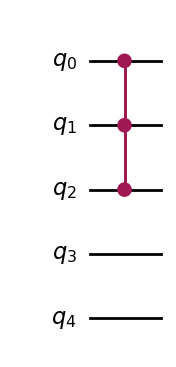

In [12]:
oracle = QuantumCircuit(5)
oracle.ccz(0, 1, 2)             # flips the phase of the target qubit if the control qubits are in the ∣11⟩ state.
oracle.draw(output="mpl")

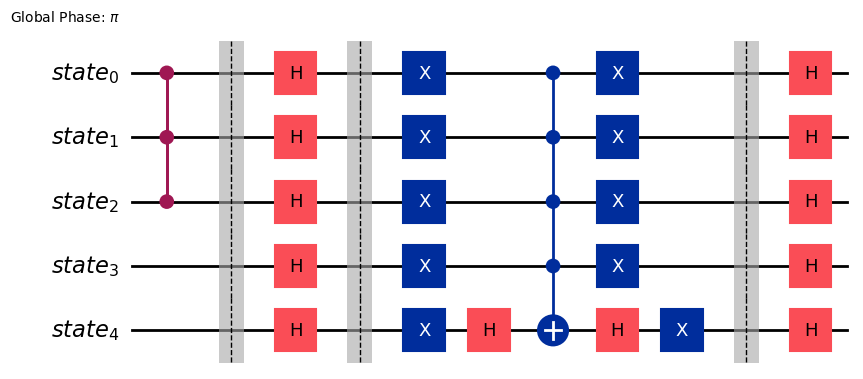

In [13]:
from qiskit.circuit.library import GroverOperator

grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.decompose().draw(output="mpl")

But we know that we only need to consider the first three:

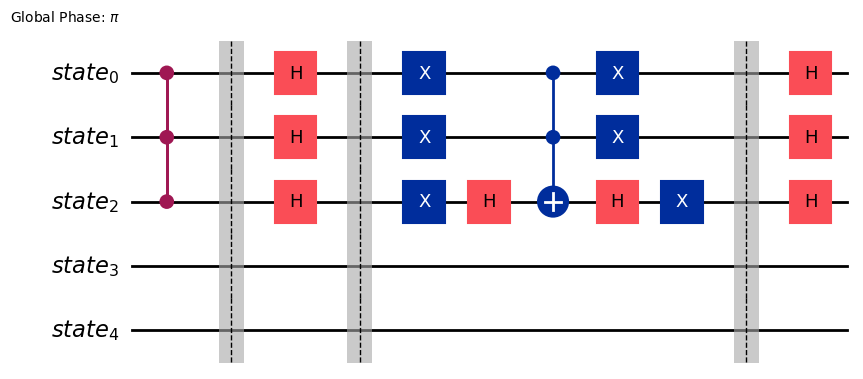

In [14]:
grover_op = GroverOperator(oracle, reflection_qubits=[0, 1, 2], insert_barriers=True)
grover_op.decompose().draw(output="mpl")

#### Specifying a good state

`good_state` can be a list of binary strings, a list of integer, `Statevector`, and Callable. If the input is a list of bitstrings, each bitstrings in the list represents a good state. If the input is a list of integer, each integer represent the index of the good state to be $|1\rangle$ . If it is a `Statevector`, it represents a superposition of all good states.

In [15]:
# a list of binary strings good state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = ["11", "00"]
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state("11"))

True


In [16]:
# a list of integer good state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = [0, 1]
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state("11"))

True


In [17]:
from qiskit.quantum_info import Statevector

# `Statevector` good state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = Statevector.from_label("11")
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state("11"))

True


In [18]:
# Callable good state
def callable_good_state(bitstr):
    if bitstr == "11":
        return True
    return False


oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state("11"))

True


#### The number of iterations

In [19]:
# integer iteration
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=["11"])
grover = Grover(iterations=1)

In [20]:
# list iteration
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=["11"])
grover = Grover(iterations=[1, 2, 3])

In [21]:
# using sample_from_iterations
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=["11"])
grover = Grover(iterations=[1, 2, 3], sample_from_iterations=True)

In [22]:
iterations = Grover.optimal_num_iterations(num_solutions=1, num_qubits=8)
iterations

12

#### Applying `post_processing`

We can apply an optional post processing for ease of readability:

In [23]:
def to_DIAMACS_CNF_format(bit_rep):
    return [index + 1 if val == 1 else -1 * (index + 1) for index, val in enumerate(bit_rep)]


oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=["11"], post_processing=to_DIAMACS_CNF_format)
problem.post_processing([1, 0, 1])

[1, -2, 3]

## Finding solutions to 3-SAT problems

Code from [IBM QISKIT Grover Examples](https://qiskit-community.github.io/qiskit-algorithms/tutorials/07_grover_examples.html)

An example 3-Satisfiability (3-SAT) problem and walk-through how we can use Quantum Search to find its satisfying solutions. 
3-SAT problems are usually expressed in Conjunctive Normal Forms (CNF) and written in the DIMACS-CNF format. 

For example:

In [24]:
input_3sat_instance = """
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
"""

The CNF of this 3-SAT instance contains 3 variables and 5 clauses:

$$
(\neg v_1 \lor \neg v_2 \lor \neg v_3) \land (v_1 \lor \neg v_2 \lor v_3) \land ( v_1 \lor v_2 \lor \neg v_3) \land (v_1 \lor \neg v_2 \lor \neg v_3) \land (\neg v_1 \lor v_2 \lor v_3)
$$

It can be verified that this 3-SAT problem instance has three satisfying solutions:

$$
(v_1, v_2, v_3) = (T,F,T) or (F,F,F) or (T,T,F)
$$

Or, expressed using the DIMACS notation:

`1 -2 3` or `-1 -2 -3` or `1 2 -3`


Construct a oracle circuit:

In [25]:
import os
import tempfile
from qiskit.exceptions import MissingOptionalLibraryError
from qiskit.circuit.library.phase_oracle import PhaseOracle

fp = tempfile.NamedTemporaryFile(mode="w+t", delete=False)
fp.write(input_3sat_instance)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except ImportError as ex:
    print(ex)
finally:
    os.remove(file_name)

The `oracle` can now be used to create an Grover instance:

In [26]:
from qiskit_algorithms import AmplificationProblem

problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

In [27]:
from qiskit_algorithms import Grover
from qiskit.primitives import Sampler

grover = Grover(sampler=Sampler())
result = None
if problem is not None:
    result = grover.amplify(problem)
    print(result.assignment)

000


/var/folders/1r/88yy9y2s19n70brn4mjzj3q80000gn/T/ipykernel_59444/852366760.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


As seen above, a satisfying solution to the specified 3-SAT problem is obtained. And it is indeed one of the three satisfying solutions.

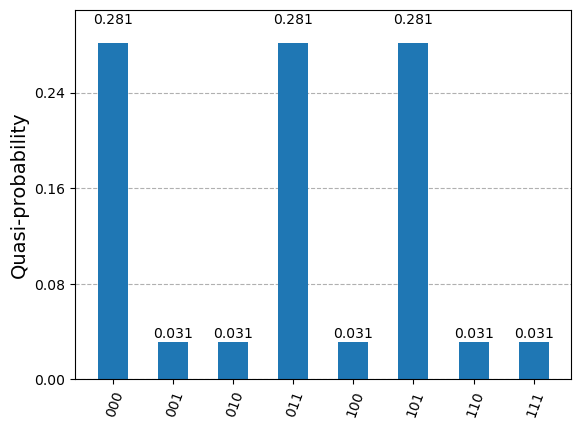

In [28]:
from qiskit.visualization import plot_histogram

if result is not None:
    display(plot_histogram(result.circuit_results[0]))

As seen above, a satisfying solution to the specified 3-SAT problem is obtained. And it is indeed one of the three satisfying solutions.

#### Boolean Logical Expressoins

Perform Quantum Search on an Oracle constructed from, for example, the `PhaseOracle` configured using arbitrary Boolean logical expressions, as demonstrated below.

/var/folders/1r/88yy9y2s19n70brn4mjzj3q80000gn/T/ipykernel_59444/1049556995.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


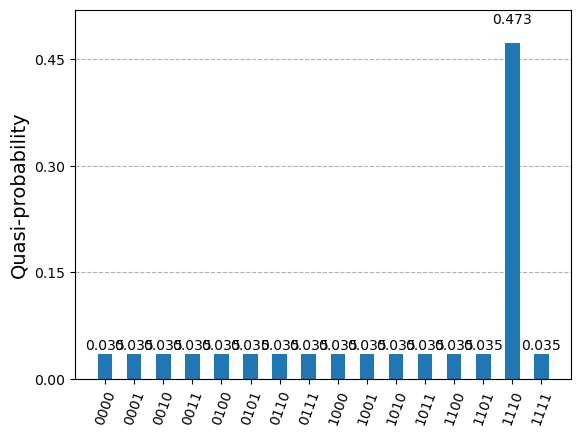

In [29]:
expression = "(w ^ x) & ~(y ^ z) & (x & y & z)"
try:
    oracle = PhaseOracle(expression)
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
    grover = Grover(sampler=Sampler())
    result = grover.amplify(problem)
    display(plot_histogram(result.circuit_results[0]))
except MissingOptionalLibraryError as ex:
    print(ex)

## Other resources

[](https://github.com/Nakshatra05/Grovers-Algorithm/blob/main/oracle.py)

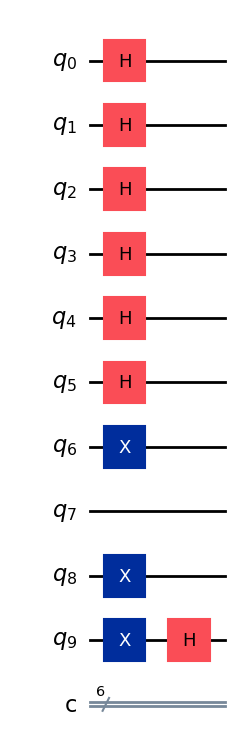

In [30]:
qc = QuantumCircuit(10,6)
for i in range(6):
    qc.h(i)
qc.x(6)
qc.x(8)
qc.x(9)
qc.h(9)
qc.draw("mpl")

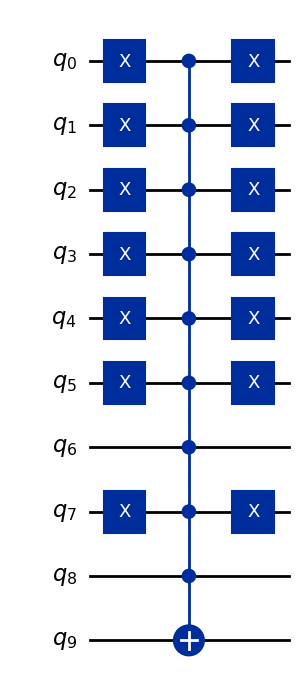

In [32]:
cq = QuantumCircuit(10)
for i in range(6):
    cq.x(i)
cq.x(7)
cq.mcx([0,1,2,3,4,5,6,7,8],9)
for i in range(6):
    cq.x(i)
cq.x(7)
cq.draw("mpl")

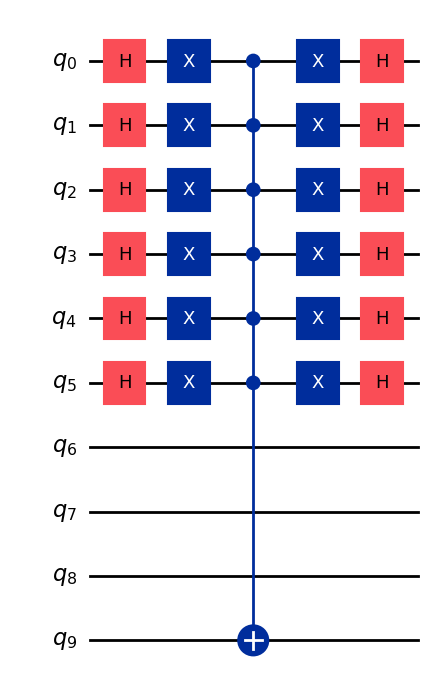

In [33]:
c = QuantumCircuit(10)
for i in range(6):
    c.h(i)
    c.x(i)
c.mcx([0,1,2,3,4,5],9)
for i in range(6):
    c.x(i)
    c.h(i)
c.draw("mpl")

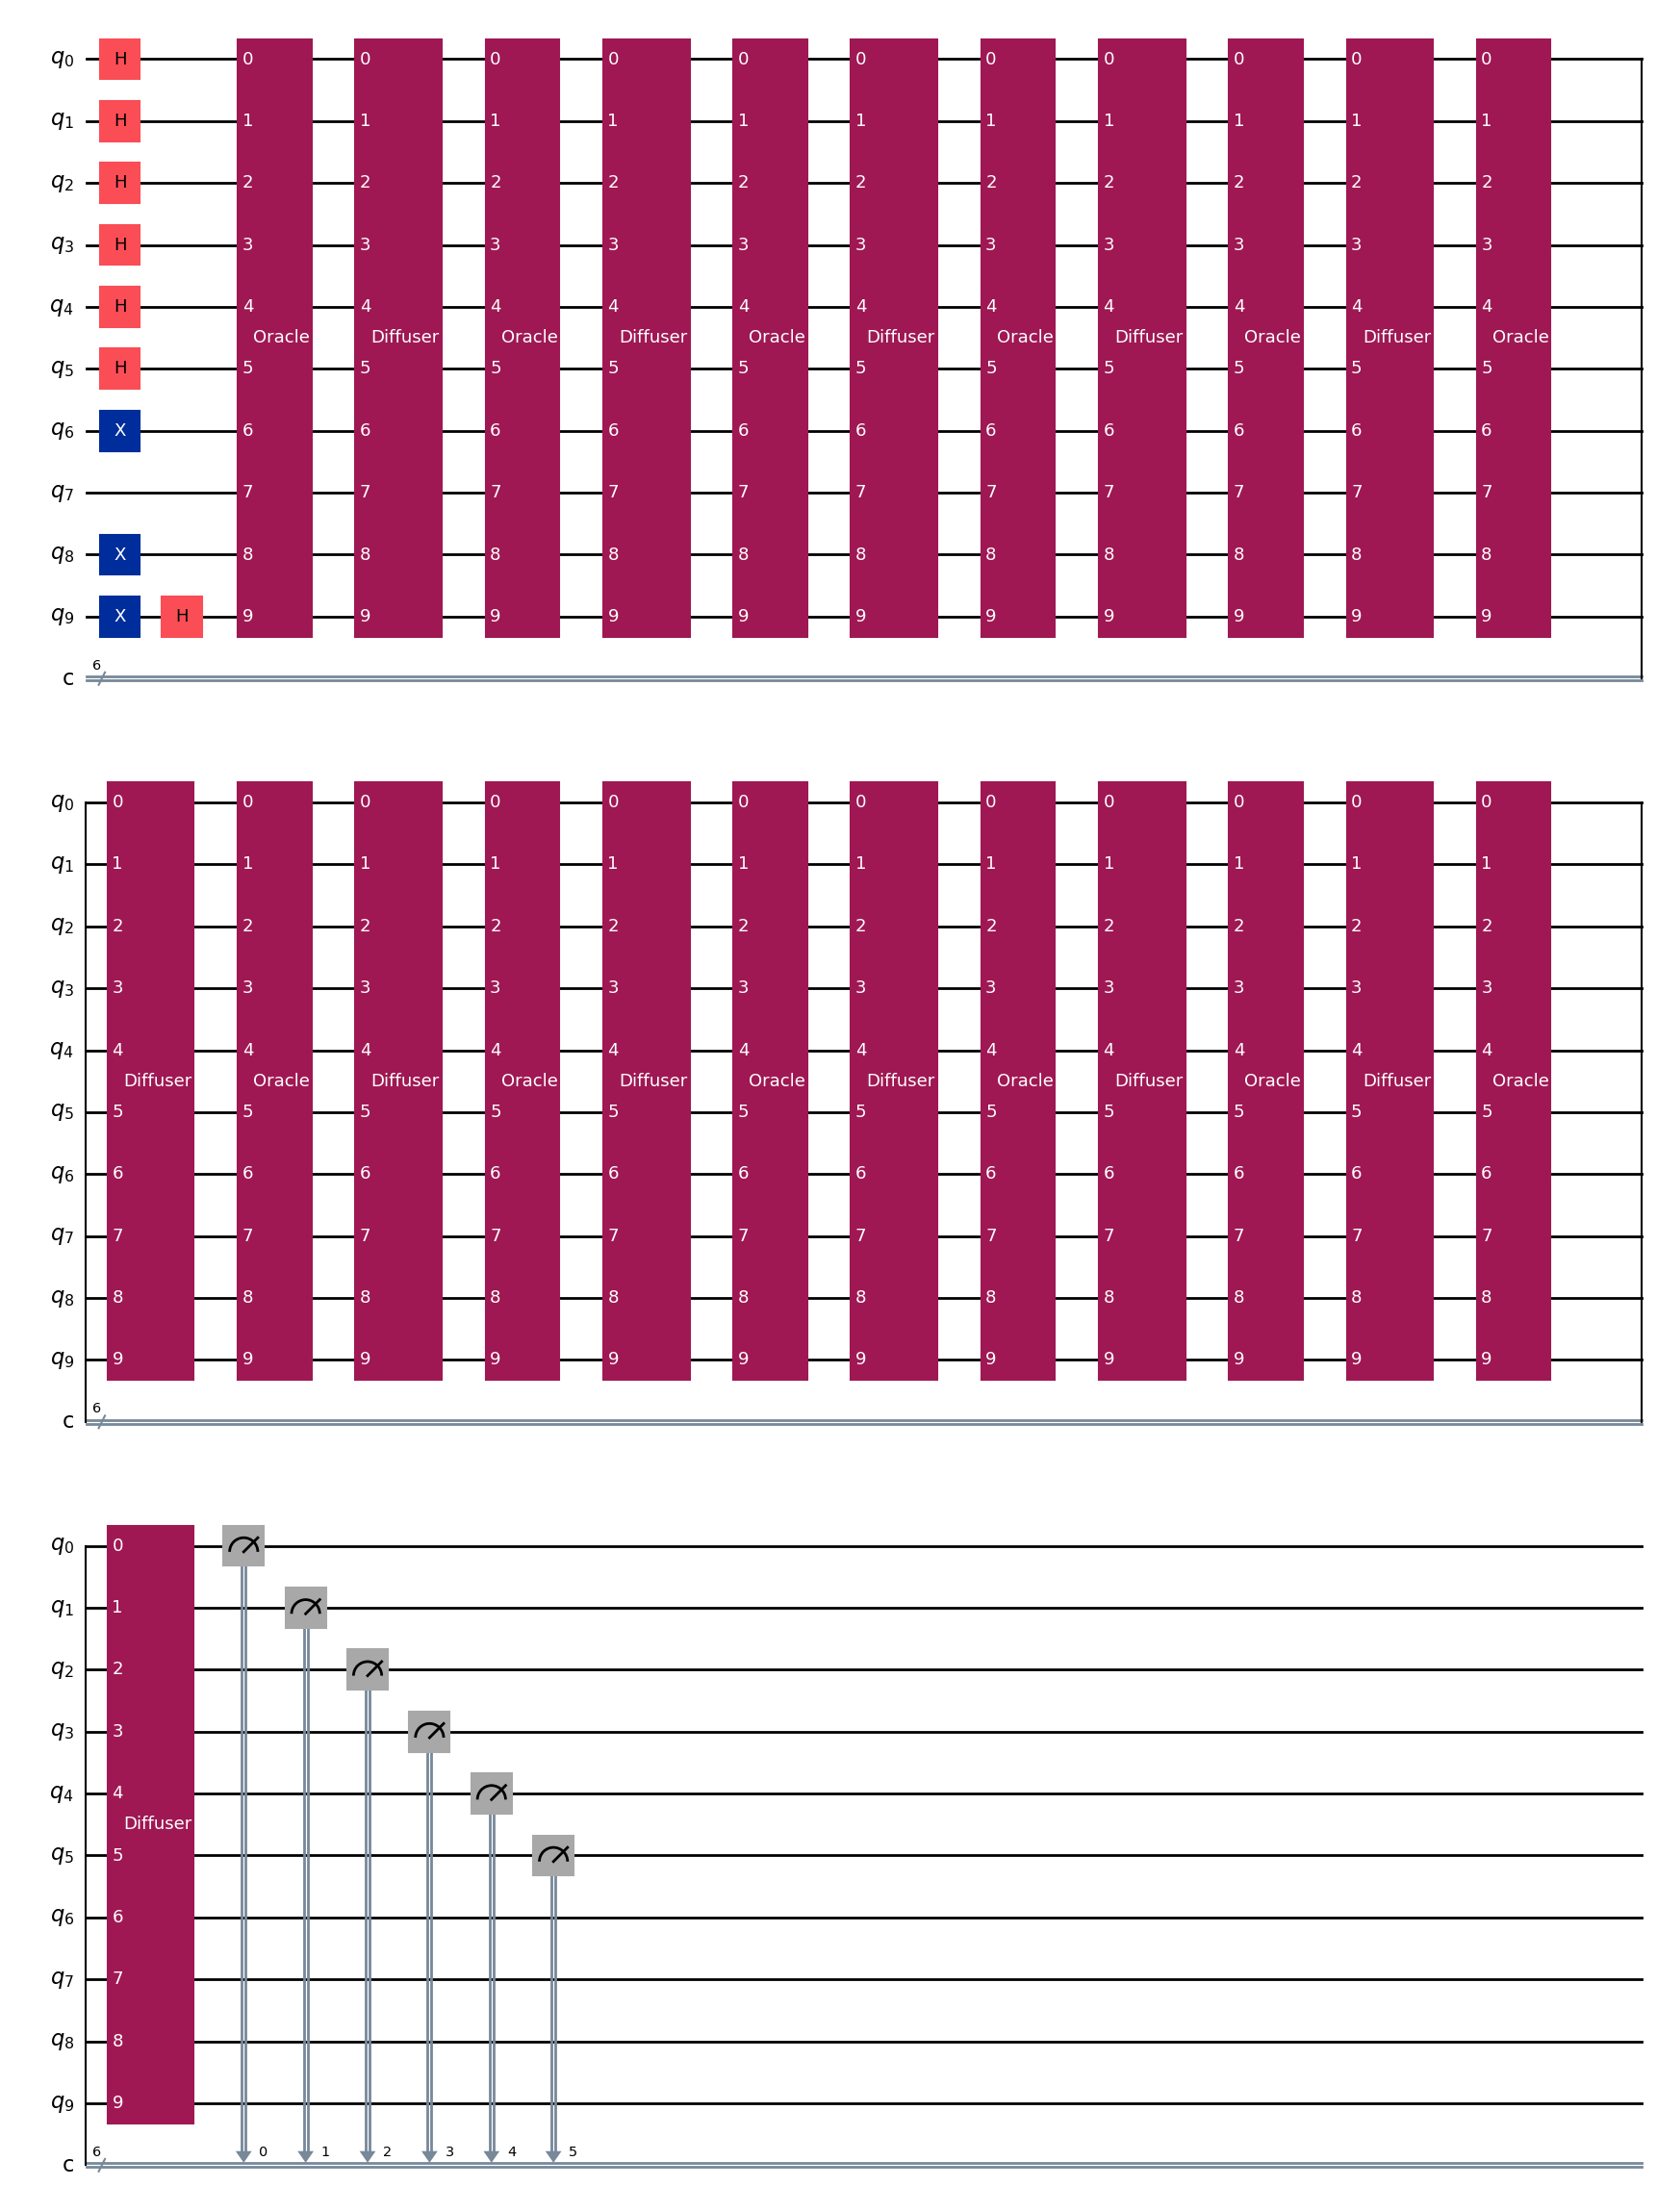

In [35]:
# conversion of oracle and diffuser as gates
gate1 = cq.to_gate()
gate1.label = "Oracle"
gate2 = c.to_gate()
gate2.label = "Diffuser"
for i in range(6):
    qc.append(gate1,list(range(0,10)))
    qc.append(gate2,list(range(0,10)))


# measure the qubits and plot it
for i in range(6):
    qc.measure(i,i)

qc.draw("mpl")


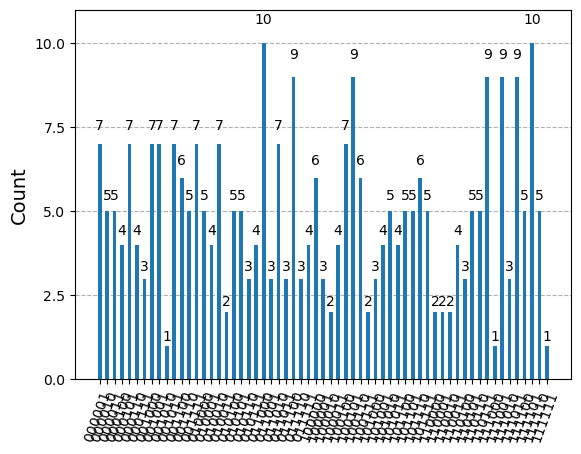

In [36]:
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
result = simulator.run(qc_t, shots=300).result()
counts = result.get_counts()
plot_histogram(counts)